In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import statsmodels.formula.api as smf

sns.set_context("paper", font_scale=1.7)
sns.set_style("ticks", {"axes.grid": True, "grid.color": "0.95", "grid.linestyle": "-"})

# Jia Replication

In [3]:
n = 3000
delta = 1/n

MC = 1000
RV = np.zeros((MC,1))
se = np.zeros((MC,1))

sigma = ((np.arange(1,n+1))/n - 0.6)**2 * 2 + 0.5
IV = np.sum(np.power(sigma,2)) * delta

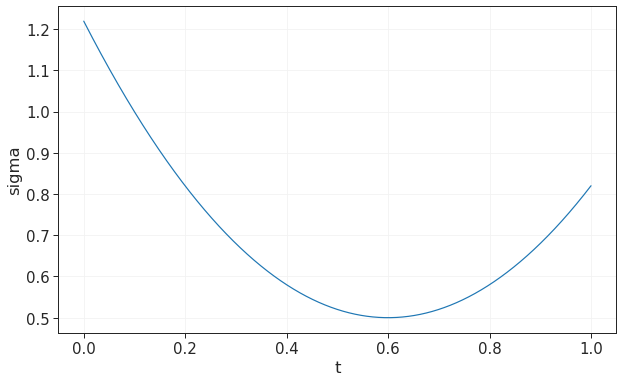

In [4]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(1,n+1)/n, sigma); plt.xlabel('t'); plt.ylabel('sigma');

In [5]:
# Monte Carlo
for mc in range(MC):
    dW = np.random.normal(0,np.sqrt(delta),(n))
    r = np.multiply(sigma, dW)
    RV[mc] = np.sum(np.square(r))
    se[mc] = np.sqrt(2 * np.sum(np.power(r,4))/3 )
    
# Estimation error
e = RV - IV

Mean(error): 0.00016249554 
StDev(error): 0.015208823 


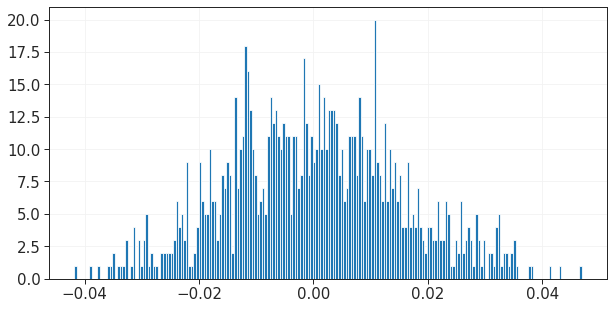

In [6]:
plt.figure(figsize=(10,5))
plt.hist(e, bins = 200); 
print(f'Mean(error): {np.mean(e):.8} ')
print(f'StDev(error): {np.std(e):.8} ')

In [7]:
# Estimated standard error
np.mean(se)

0.015209393229193457

$$t = (x-\mu_x)/\sigma_x$$

In [8]:
# t-statistics
t = np.divide(e, se)

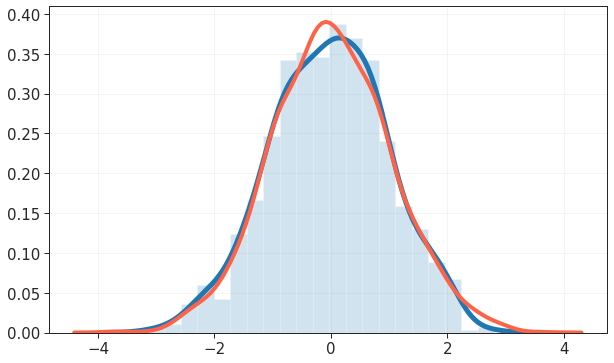

In [9]:
plt.figure(figsize=(10,6))
sns.distplot(t, kde_kws = {'lw':5}, hist_kws = {'alpha':0.2})
sns.distplot(np.random.normal(0,1,(n)), hist = False, color = 'tomato', kde_kws = {'lw':4})

In [10]:
np.mean(np.abs(t) <= stats.norm.ppf(0.975)) 

0.946

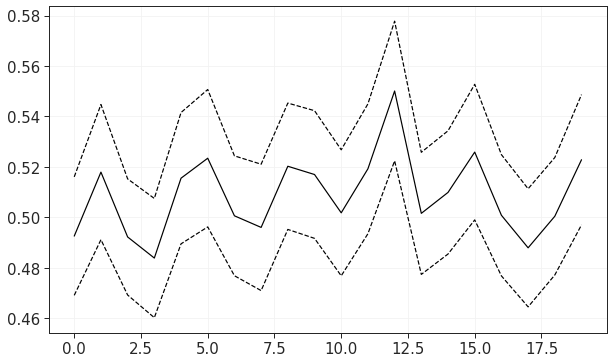

In [11]:
z = stats.norm.ppf(0.95)
L90 = RV - z * se
U90 = RV + z * se

plt.figure(figsize = (10,6))
plt.plot(RV[:20], color = 'k')
plt.plot(L90[:20], color = 'k', ls = 'dashed')
plt.plot(U90[:20], color = 'k', ls = 'dashed')

# Main

## Simulation Class

In [12]:
class SimRV:
    def montecarlo(self, sigma_f, T=1, n = 100, mc_trials = 100):
        
        ## Set up
        # Params 
        delta = T/n
        
        # Result variables
        RV = np.zeros((mc_trials))
        se = np.zeros((mc_trials))
        
        # Volatility
        sigma = sigma_f(np.linspace(0,T,n))
        IV = np.sum(np.square(sigma)) * delta
        
        ## Run monte carlo
        for mc in range(mc_trials):
            dW = np.random.normal(0,1,(n))*np.sqrt(delta)
            r = np.multiply(sigma, dW)
            RV[mc] = np.sum(np.square(r))
            se[mc] = np.sqrt(2/3 * np.sum(np.power(r,4)))
        
        # Estimation error
        e = RV - IV
        
        # t-stat
        t = np.divide(e,se)
        
        ## Save results
        # Params
        self.n = n
        self.mc_trials = mc_trials
        self.sigma = sigma
        self.IV = IV
        
        # Results
        self.RV = RV
        self.se = se
        self.e = e
        self.t = t

## Example Sim

In [49]:
simulation = SimRV()
sigma_f = lambda x: (x/390-0.6)**2 * 2 + 0.5

T = 390
n = 300
delta = T/n
simulation.montecarlo(sigma_f, T = T, n = n, mc_trials = 1000)

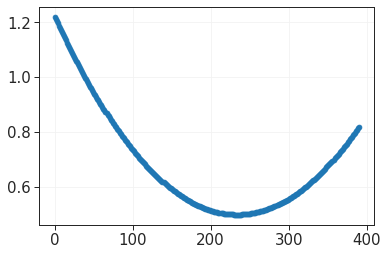

In [50]:
plt.plot(np.linspace(0,T,1000), sigma_f(np.linspace(0,T,1000)))
plt.scatter(np.linspace(0,T,n), sigma_f(np.linspace(0,T,n)))

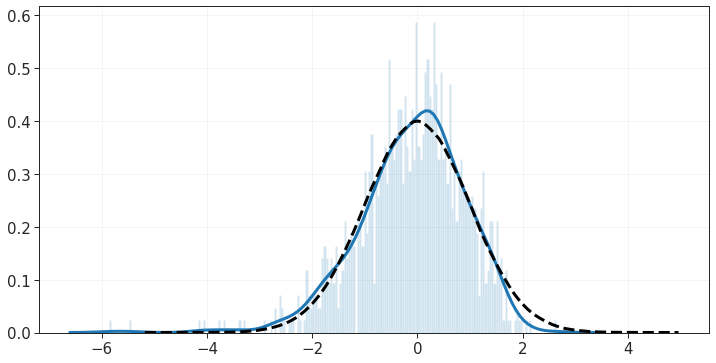

In [51]:
plt.figure(figsize=(12,6))
sns.distplot(simulation.t, bins = 200, kde_kws = {'lw':3}, hist_kws = {'alpha':0.2})
sns.distplot(np.random.normal(0,1,(int(1e6))), color = 'k', hist = False, kde_kws = {'lw':3, 'ls':'dashed'})

## Set up sigma_t

IV/T
[0.010000000000000009, 0.010000031460697393, 0.010000482902409525]


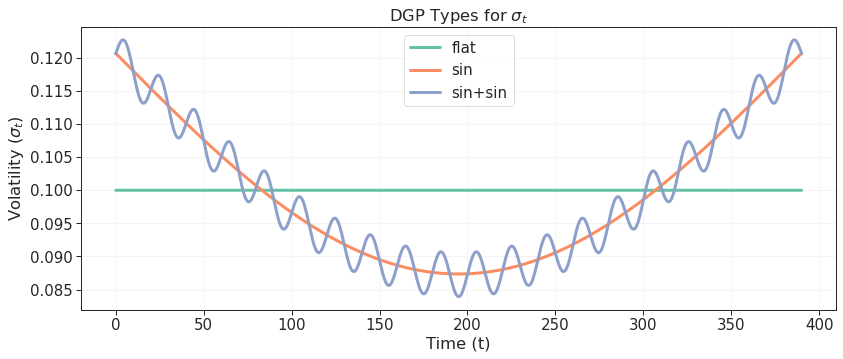

In [52]:
## How sigma evolves over time
sigma_f_x_alpha = (
    lambda x, alpha: (3
    + (np.sin(np.pi * x / 390 + np.pi)+0.62079) * alpha[0]
    + np.sin(np.pi * x / 10) * alpha[1] + alpha[1]*(-0.0275))/30
)

alpha_list = [[0, 0], [1, 0], [1, 1 / 10]]
sigma_f_x_list = [
    lambda x: sigma_f_x_alpha(x, alpha_list[0]),
    lambda x: sigma_f_x_alpha(x, alpha_list[1]),
    lambda x: sigma_f_x_alpha(x, alpha_list[2]),
]

print('IV/T')
print([np.sum(np.square(sigma_f(np.linspace(0,390,100000))))*(1/100000) for sigma_f in sigma_f_x_list])

plt.figure(figsize=(12, 5))
for i in range(len(sigma_f_x_list)):
    plt.plot(
        np.linspace(0, 390, 100000),
        sigma_f_x_list[i](np.linspace(0, 390, 100000)),
        color = sns.color_palette("Set2", 3)[i],
        lw=3,
        label=['flat', 'sin', 'sin+sin'][i]# + f" $\\alpha_0$ = {alpha_list[i][0]}, $\\alpha_1$ = {alpha_list[i][1]}",
    )
    plt.legend(loc = 'upper center')
    plt.ylim()
    plt.ylabel('Volatility ($\\sigma_t$)')
    plt.xlabel('Time (t)')
    
plt.tight_layout()
plt.title('DGP Types for $\\sigma_t$')
plt.savefig('../exhibits/dgp_vol.pdf')

## Delta_n Simulation

In [53]:
simulation = SimRV()

# Length of time
T = 390

# Range of n to consider
n_range = [int(x) for x in [390*(60/5), 390*(60/15), 390*(60/30), 390, 390/3, 390/5, 390/10, 390/15, 390/30]]
print(f'n = {n_range}')

# Monte Carlo trials
mc_trials = 5000

# For storing the output of the results for each sigma_f
results_df_list = []

for j in range(len(alpha_list)):
    
    # How sigma evolves over time
    sigma_f = lambda x: sigma_f_x_alpha(x, alpha_list[j])

    # Numerically integrate to get IV
    IV = np.sum(np.square(sigma_f(np.linspace(0,T,100000))))*(T/100000)

    # For storing results
    results_bias = [0] * len(n_range)
    results_t = [0] * len(n_range)

    for i in tqdm(range(len(n_range)), desc = f'alpha = {alpha_list[j]}'):

        # Sample size for monte carlo
        n = n_range[i]

        # Run montecarlo
        simulation.montecarlo(sigma_f, T=T, n=n, mc_trials=mc_trials)

        # Store results
        results_bias[i] = (simulation.e).copy()
        results_t[i] = (simulation.t).copy()
        
    ## Average out results across mc trials
    # Root mean square error
    results_rmse = [np.sqrt(np.sum(np.square(x))) for x in results_bias]

    # Mean bias
    results_mean_bias = [np.mean(x) for x in results_bias]

    # Dataframe
    results_alpha_df = pd.DataFrame([n_range, results_mean_bias, results_rmse, results_t]).T
    results_alpha_df.columns = ['n', 'bias', 'rmse', 't']
    results_alpha_df['alpha'] = [alpha_list[j]]*len(n_range)
    results_alpha_df['sigma_type'] = ['flat', 'sin', 'sin + sin'][j]
    results_df_list.append(results_alpha_df)
        
results_df = pd.concat(results_df_list).reset_index(drop=True)
results_df['n'] = results_df['n'].astype(int)
results_df['bias'] = results_df['bias'].astype(float)
results_df['rmse'] = results_df['rmse'].astype(float)

n = [4680, 1560, 780, 390, 130, 78, 39, 26, 13]


In [54]:
results_df.sample(5)

,n,bias,rmse,t,alpha,sigma_type
21,390,0.001833,20.540774,"[-0.642520220835924, -1.3742593972641095, 1.35...","[1, 0.1]",sin + sin
26,13,-0.013390,115.628970,"[-1.0837647102461538, 0.21319274773222055, -0....","[1, 0.1]",sin + sin
16,26,-0.012508,79.420618,"[-0.0854322274289167, -1.5633023137195345, 0.3...","[1, 0]",sin
5,78,0.026276,43.861398,"[0.6530442779404542, -0.39961677856582606, 0.7...","[0, 0]",flat
15,39,-0.000659,65.555371,"[-2.874286062668767, 0.632190580201743, -0.551...","[1, 0]",sin


In [55]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   n           27 non-null     int64  
 1   bias        27 non-null     float64
 2   rmse        27 non-null     float64
 3   t           27 non-null     object 
 4   alpha       27 non-null     object 
 5   sigma_type  27 non-null     object 
dtypes: float64(2), int64(1), object(3)
memory usage: 1.4+ KB


### Bias RMSE Table

In [56]:
results_df['Delta_n'] = (T/results_df['n']).round(2)

In [57]:
for st in results_df["sigma_type"].unique():
    print(st)
    print(
        results_df.query("sigma_type == @st")
        .sort_values(by=["sigma_type", "n"])[["n", "Delta_n", "bias", "rmse"]]
        .round(4)
        .set_index("n")
        .to_latex()
    )

flat
\begin{tabular}{lrrr}
\toprule
{} &  Delta\_n &    bias &      rmse \\
n    &          &         &           \\
\midrule
13   &    30.00 & -0.0170 &  106.4636 \\
26   &    15.00 & -0.0195 &   75.2564 \\
39   &    10.00 & -0.0174 &   62.5317 \\
78   &     5.00 &  0.0263 &   43.8614 \\
130  &     3.00 &  0.0063 &   34.7300 \\
390  &     1.00 & -0.0017 &   19.7944 \\
780  &     0.50 & -0.0008 &   14.0396 \\
1560 &     0.25 & -0.0041 &    9.8859 \\
4680 &     0.08 &  0.0007 &    5.7030 \\
\bottomrule
\end{tabular}

sin
\begin{tabular}{lrrr}
\toprule
{} &  Delta\_n &    bias &      rmse \\
n    &          &         &           \\
\midrule
13   &    30.00 & -0.0526 &  113.8953 \\
26   &    15.00 & -0.0125 &   79.4206 \\
39   &    10.00 & -0.0007 &   65.5554 \\
78   &     5.00 &  0.0012 &   45.5035 \\
130  &     3.00 & -0.0083 &   34.8584 \\
390  &     1.00 &  0.0023 &   20.1571 \\
780  &     0.50 &  0.0011 &   14.1894 \\
1560 &     0.25 &  0.0028 &   10.1325 \\
4680 &     0.08 & -0.0015

### RMSE Plot

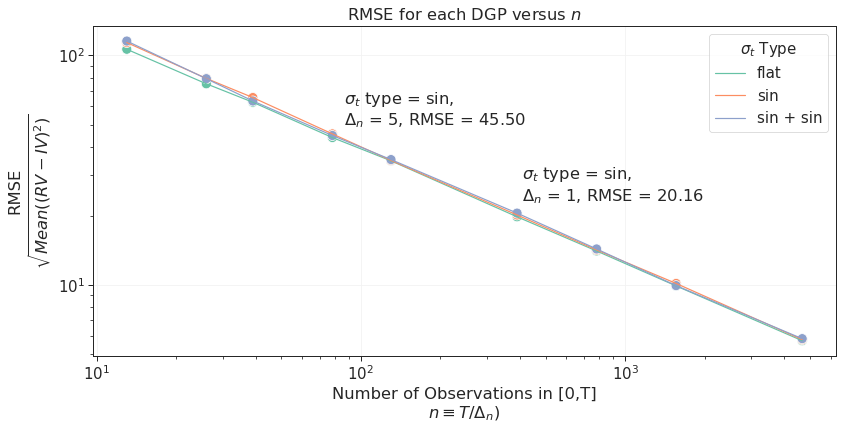

In [60]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.lineplot(
    x="n", y="rmse", hue="sigma_type", palette=sns.color_palette("Set2", 3), data=results_df, ax=ax
)
sns.scatterplot(
    x="n",
    y="rmse",
    hue="sigma_type",
    palette=sns.color_palette("Set2", 3),
    legend=False,
    data=results_df,
    **{"s": 100},
    ax=ax,
)
plt.yscale("log")
plt.xscale("log")

# Labels
plt.ylabel("RMSE\n$\sqrt{Mean((RV-IV)^2)}$")
plt.xlabel("Number of Observations in [0,T]\n$n \equiv T/\Delta_n)$")

# Fix legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=labels[1:], title="$\sigma_t$ Type", fontsize=15, title_fontsize=15)


# Text labels at points
example_df = results_df.query('sigma_type == "sin"').reset_index(drop=True)
plt.text(
    example_df.loc[3, "n"] + 16,
    example_df.loc[3, "rmse"] + 3,
    f'$\\sigma_t$ type = sin,\n$\Delta_n$ = {T/example_df.loc[3, "n"]:.0f}, RMSE = {example_df.loc[3, "rmse"]:0.2f}',
)
plt.text(
    example_df.loc[5, "n"] + 8,
    example_df.loc[5, "rmse"] + 4,
    f'$\\sigma_t$ type = sin,\n$\Delta_n$ = {T/example_df.loc[5, "n"]:.0f}, RMSE = {example_df.loc[5, "rmse"]:0.2f}',
);

plt.tight_layout()
plt.title('RMSE for each DGP versus $n$')
plt.savefig('../exhibits/rmse.pdf')

In [61]:
smf.ols('np.log(rmse) ~ np.log(Delta_n)', data = results_df.query('sigma_type == "sin"')[['Delta_n', 'rmse']]).fit().summary()

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(rmse)   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.371e+04
Date:                Wed, 23 Sep 2020   Prob (F-statistic):           2.43e-15
Time:                        16:21:37   Log-Likelihood:                 29.358
No. Observations:                   9   AIC:                            -54.72
Df Residuals:                       7   BIC:                            -54.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.0114      0.004    802.433      0.000       3.002       3.020
np.log(Delta_n)     0.5040      0.002    271.502      0.000       0.500       0.508
==============================================================================
Omnibus:                        1.789   Durbin-Watson:                   1.185
Prob(Omnibus):                  0.409   Jarque-Bera (JB):                0.764
Skew:                           0.095   Prob(JB):                        0.682
Kurtosis:                       1.585   Cond. No.                         2.25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Density Plot

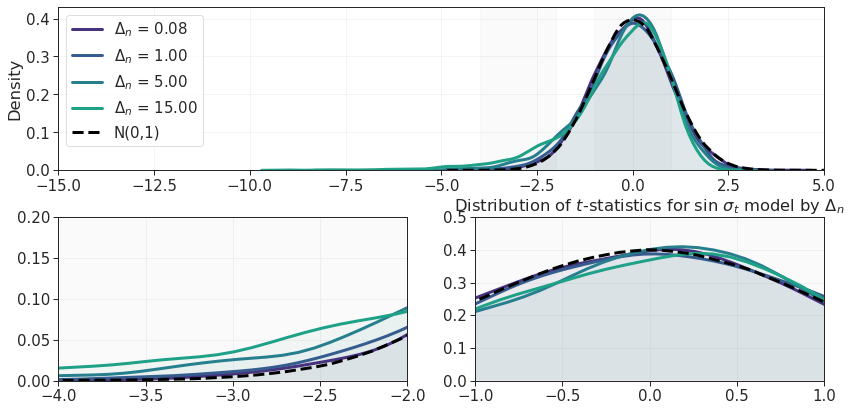

In [63]:
plt.figure(figsize=(12, 6))

results_df_subset = results_df.query('sigma_type == "sin"')

# Draw a kernel density curve for the empirical t-stat distribution under different values of n
def temp_plot():
    
    n_subset = [int(x) for x in [390*(60/5), 390, 390/5, 390/15]]
    
    for i in range(len(n_subset)):
        sns.distplot(
            results_df_subset.set_index('n').loc[n_subset[i], 't'],
            label=f'$\\Delta_n$ = {T/n_subset[i]:.2f}',
            bins=200,
            color=sns.color_palette("viridis", 6)[i],
            kde_kws={"lw": 3},
            hist = False,
        )
        # Trick to get shaded region to be a lower alpha than the lines
        sns.distplot(
            results_df_subset.set_index('n').loc[n_subset[i], 't'],
            bins=200,
            color=sns.color_palette("viridis", 6)[i],
            kde_kws={"lw": 0, 'shade':True, 'alpha':0.04},
            hist = False
        )

    sns.distplot(
        np.random.normal(0, 1, (int(1e6))),
        label="N(0,1)",
        color="k",
        hist=False,
        kde_kws={"lw": 3, "ls": "dashed"},
    )

plt.subplot(211)
plt.axvspan(-4, -2, color = 'k', alpha = 0.02)
plt.axvspan(-1, 1, color = 'k', alpha = 0.02)
temp_plot()
plt.xlim(-15, 5)
plt.ylabel('Density')

ax = plt.subplot(223)
temp_plot()
plt.axvspan(-4, -2, color = 'k', alpha = 0.02)
plt.xlim(-4, -2)
plt.ylim(0, 0.2)
ax.get_legend().remove()

ax = plt.subplot(224)
temp_plot()
plt.axvspan(-1, 1, color = 'k', alpha = 0.02)
plt.xlim(-1, 1)
plt.ylim(0, 0.5)
ax.get_legend().remove()

plt.tight_layout()
plt.title('Distribution of $t$-statistics for sin $\sigma_t$ model by $\Delta_n$')
plt.savefig('../exhibits/tdist.pdf')

### Coverage Rates

In [64]:
# Add coverage rates
results_df['coverage_90'] = results_df['t'].apply(lambda t: np.mean(np.abs(t) < stats.norm.ppf(0.95)))*100
results_df['coverage_95'] = results_df['t'].apply(lambda t: np.mean(np.abs(t) < stats.norm.ppf(0.975)))*100
results_df['coverage_99'] = results_df['t'].apply(lambda t: np.mean(np.abs(t) < stats.norm.ppf(0.995)))*100

In [65]:
for st in results_df["sigma_type"].unique():
    print(st)
    print(
        results_df.query("sigma_type == @st")
        .sort_values(by=["sigma_type", "n"])[["n", "Delta_n", "coverage_90", "coverage_95", "coverage_99"]]
        .round(4)
        .set_index("n")
        .to_latex()
    )

flat
\begin{tabular}{lrrrr}
\toprule
{} &  Delta\_n &  coverage\_90 &  coverage\_95 &  coverage\_99 \\
n    &          &              &              &              \\
\midrule
13   &    30.00 &        82.38 &        86.62 &        91.24 \\
26   &    15.00 &        85.60 &        89.96 &        94.64 \\
39   &    10.00 &        86.66 &        91.22 &        95.58 \\
78   &     5.00 &        89.00 &        93.86 &        97.76 \\
130  &     3.00 &        88.96 &        93.58 &        98.08 \\
390  &     1.00 &        89.64 &        94.46 &        98.52 \\
780  &     0.50 &        89.58 &        94.70 &        98.72 \\
1560 &     0.25 &        89.66 &        94.50 &        98.78 \\
4680 &     0.08 &        89.86 &        94.88 &        98.86 \\
\bottomrule
\end{tabular}

sin
\begin{tabular}{lrrrr}
\toprule
{} &  Delta\_n &  coverage\_90 &  coverage\_95 &  coverage\_99 \\
n    &          &              &              &              \\
\midrule
13   &    30.00 &        81.38 &        85.28 

## T Simulation

In [67]:
simulation = SimRV()

# Length of time
T_range = [390, 390*5, 390*21]

# Range of n to consider
n_range = [int(x/(5)) for x in T_range]
print(f'n = {n_range}')

# Monte Carlo trials
mc_trials = 5000

# For storing the output of the results for each sigma_f
results_df_list = []

for j in range(len(T_range)):
    
    # How sigma evolves over time
    sigma_f = lambda x: sigma_f_x_alpha(x, alpha_list[0])
    
    # T
    T = T_range[j]

    # Numerically integrate to get IV
    IV = np.sum(np.square(sigma_f(np.linspace(0,T,100000))))*(T/100000)

    # For storing results
    results_bias = [0] * len(n_range)
    results_t = [0] * len(n_range)
    results_rv = [0] * len(n_range)
    results_se = [0] * len(n_range)
    
    for i in tqdm(range(len(n_range)), desc = f'T = {T_range[j]}'):

        # Sample size for monte carlo
        n = n_range[i]

        # Run montecarlo
        simulation.montecarlo(sigma_f, T=T, n=n, mc_trials=mc_trials)

        # Store results
        results_bias[i] = (simulation.e).copy()
        results_t[i] = (simulation.t).copy()
        results_rv[i] = (simulation.RV).copy()
        results_se[i] = (simulation.se).copy()
        
    ## Average out results across mc trials
    # Root mean square error
    results_rmse = [np.sqrt(np.sum(np.square(x))) for x in results_bias]

    # Mean bias
    results_mean_bias = [np.mean(x) for x in results_bias]

    # Dataframe
    results_alpha_df = pd.DataFrame([n_range, results_mean_bias, results_rmse, results_t, results_se, results_rv]).T
    results_alpha_df.columns = ['n', 'bias', 'rmse', 't', 'se', 'rv']
    results_alpha_df['alpha'] = [alpha_list[j]]*len(n_range)
    results_alpha_df['T'] = T
    results_alpha_df['sigma_type'] = ['flat', 'sin', 'sin + sin'][j]
    results_df_list.append(results_alpha_df)
        
results_df = pd.concat(results_df_list).reset_index(drop=True)
results_df['n'] = results_df['n'].astype(int)
results_df['bias'] = results_df['bias'].astype(float)
results_df['rmse'] = results_df['rmse'].astype(float)

n = [78, 390, 1638]


In [68]:
results_df['Delta_n'] = (results_df['T']/results_df['n']).astype(int)
results_df['rv_mean'] = results_df['rv'].apply(lambda x: np.mean(x))
results_df['se_mean'] = results_df['se'].apply(lambda x: np.mean(x))

for col in ['rv_mean', 'se_mean', 'rmse']:
    results_df[col] = results_df[col].round(3)

### Stats for RV

In [75]:
[np.std(rv) for rv in results_df.query('Delta_n==5')['rv']]

[0.6336923776684955, 1.3648435257087974, 2.8280689194826727]

In [76]:
 np.square(1.3648435257087974/0.633)

4.64898674450564

In [69]:
results_fixed_delta_df = results_df.query("Delta_n == 5")[["n", "Delta_n", "T", "rv_mean", "se_mean", "bias", "rmse"]]
results_fixed_n_df = results_df.query('n == 390')[["n", "Delta_n", "T", "rv_mean", "se_mean", "bias", "rmse"]]

display(results_fixed_delta_df)
display(results_fixed_n_df)

print(results_fixed_delta_df.set_index(['T', 'n', 'Delta_n']).round(5).to_latex())
print(results_fixed_n_df.set_index(['T', 'n', 'Delta_n']).round(5).to_latex())

,n,Delta_n,T,rv_mean,se_mean,bias,rmse
0,78,5,390,3.903,0.615,0.002530,44.809
4,390,5,1950,19.492,1.390,-0.007972,96.511
8,1638,5,8190,81.915,2.859,0.015061,199.978


,n,Delta_n,T,rv_mean,se_mean,bias,rmse
1,390,1,390,3.898,0.278,-0.001931,19.666
4,390,5,1950,19.492,1.390,-0.007972,96.511
7,390,21,8190,81.811,5.838,-0.089183,421.014


\begin{tabular}{lllrrrr}
\toprule
     &      &   &  rv\_mean &  se\_mean &     bias &     rmse \\
T & n & Delta\_n &          &          &          &          \\
\midrule
390  & 78   & 5 &    3.903 &    0.615 &  0.00253 &   44.809 \\
1950 & 390  & 5 &   19.492 &    1.390 & -0.00797 &   96.511 \\
8190 & 1638 & 5 &   81.915 &    2.859 &  0.01506 &  199.978 \\
\bottomrule
\end{tabular}

\begin{tabular}{lllrrrr}
\toprule
     &     &    &  rv\_mean &  se\_mean &     bias &     rmse \\
T & n & Delta\_n &          &          &          &          \\
\midrule
390  & 390 & 1  &    3.898 &    0.278 & -0.00193 &   19.666 \\
1950 & 390 & 5  &   19.492 &    1.390 & -0.00797 &   96.511 \\
8190 & 390 & 21 &   81.811 &    5.838 & -0.08918 &  421.014 \\
\bottomrule
\end{tabular}



### Stats for RV/T

In [ ]:
results_df['rv_mean_T_adj'] = results_df['rv_mean']/(results_df['T'])
results_df['se_mean_T_adj'] = results_df['se_mean']/(results_df['T'])
results_df['bias_T_adj'] = results_df['bias']/(results_df['T'])
results_df['rmse_T_adj'] = results_df['rmse']/(results_df['T'])


for col in ['RV_T_adj', 'se_mean_T_adj', 'rmse_T_adj']:
    results_df[col] = results_df[col].round(5)

In [ ]:
results_fixed_delta_df = results_df.query("Delta_n == 5")[
    ["n", "Delta_n", "T", "rv_mean_T_adj", "se_mean_T_adj", "bias_T_adj", "rmse_T_adj"]
]
results_fixed_n_df = results_df.query("n == 390")[
    ["n", "Delta_n", "T", "rv_mean_T_adj", "se_mean_T_adj", "bias_T_adj", "rmse_T_adj"]
]

display(results_fixed_delta_df)
display(results_fixed_n_df)

print(results_fixed_delta_df.set_index(["T", "n", "Delta_n"]).round(6).to_latex())
print(results_fixed_n_df.set_index(["T", "n", "Delta_n"]).round(6).to_latex())